In [1]:
import pandas as pd

df = pd.read_csv('../data/training.csv')
df = df.set_index('label')

### Group by and display count for each category
There are 12 categories of complaints

In [2]:
df.groupby(df.index).count()

,text
label,
Building Permission,2052
Drainage,2163
Electrical,3543
Encroachment,1376
Garbage,4007
Garden,1693
Health,2514
Property Tax,1487
Road,5347


In [3]:
# Creating a deep copy for training data
# df_for_training = df.copy()

In [4]:
# Make a dataset for training
# We are sampling 4000 entries per category, 
# thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results
df_for_training = pd.DataFrame()
SAMPLES = 5000
STATE = 0

for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

In [5]:
df_for_training['class_label'] = df_for_training.index.factorize()[0]

In [6]:
# Since the classes are now numbered, I am storing this in a mapper.


import json

mapper_df = df_for_training[['class_label']].reset_index().groupby('label').mean()
mapper = mapper_df.to_dict()['class_label']
mapper = dict([(v, k) for k, v in mapper.items()])
mapper = dict(sorted(mapper.items()))

with open("../data/mapper.json", "w") as outfile:  
    json.dump(mapper, outfile) 

In [7]:
df_for_training = df_for_training.dropna()

In [8]:
df_for_training

,text,class_label
label,,
Encroachment,complaint token m is not yet resolved,0
Encroachment,new encroachment in open spaced around,0
Encroachment,i aged had the at on march evening along with ...,0
Encroachment,due liquor shop and bar there is lane parking ...,0
Encroachment,no zone,0
...,...,...
Garbage,our society garbage not been collected since l...,11
Garbage,removal of debris,11
Garbage,no staff the road since days garbage spread on...,11


In [9]:
mapper

{0: 'Encroachment',
 1: 'Water Supply',
 2: 'Electrical',
 3: 'Stray Dogs',
 4: 'Road',
 5: 'Garden',
 6: 'Traffic',
 7: 'Property Tax',
 8: 'Health',
 9: 'Building Permission',
 10: 'Drainage',
 11: 'Garbage'}

### Let's begin training the model, now that we have our data

In [10]:
# importing libraries for the model

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC


import re
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Initializing the stemmer, stopwords and the vectorizer

stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)


In [12]:
# Creating the input set by renaming columns and shuffling

X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)

In [13]:
X

,text,label
15896,our is facing stray dog,3
28594,due to excessive tree growth the entire lane f...,5
24815,the water outage on the road at smart path nea...,4
54220,as per as citizen on the above mention road is...,10
54097,drainage line is blocked in society causing dr...,10
...,...,...
53160,drainage line block pani building aa,10
29661,te,5
47817,final plot open space plot construction war to...,9
13666,i had registered a complaint no the complaint ...,2


In [14]:
# Creating the train-test split 
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

x = X['cleaned']
y = X['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

Y_test = np.array(y_test)

In [15]:
# Initializing the models
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=10,n_jobs=4,random_state=STATE),
            'LinearSVC' : LinearSVC(),
            'MultinomialNB' : MultinomialNB(),
            'LogisticRegression' : LogisticRegression(max_iter=200,random_state=STATE),
            'RBF_SVC' : SVC(probability=True,random_state=STATE)
         }

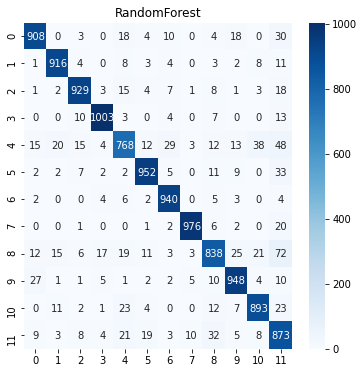

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       995
           1       0.94      0.95      0.95       960
           2       0.94      0.94      0.94       992
           3       0.96      0.96      0.96      1040
           4       0.87      0.79      0.83       977
           5       0.94      0.93      0.93      1025
           6       0.93      0.97      0.95       966
           7       0.98      0.97      0.97      1008
           8       0.88      0.80      0.84      1042
           9       0.92      0.93      0.93      1016
          10       0.92      0.91      0.92       976
          11       0.76      0.88      0.81       995

    accuracy                           0.91     11992
   macro avg       0.91      0.91      0.91     11992
weighted avg       0.91      0.91      0.91     11992



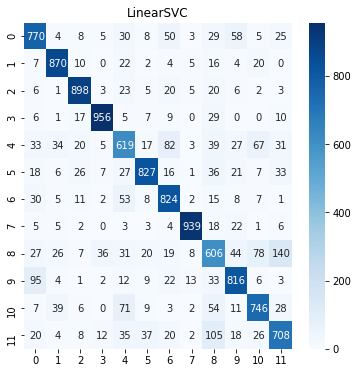

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       995
           1       0.87      0.91      0.89       960
           2       0.89      0.91      0.90       992
           3       0.93      0.92      0.92      1040
           4       0.66      0.63      0.65       977
           5       0.87      0.81      0.84      1025
           6       0.77      0.85      0.81       966
           7       0.96      0.93      0.94      1008
           8       0.61      0.58      0.59      1042
           9       0.79      0.80      0.80      1016
          10       0.77      0.76      0.77       976
          11       0.72      0.71      0.71       995

    accuracy                           0.80     11992
   macro avg       0.80      0.80      0.80     11992
weighted avg       0.80      0.80      0.80     11992



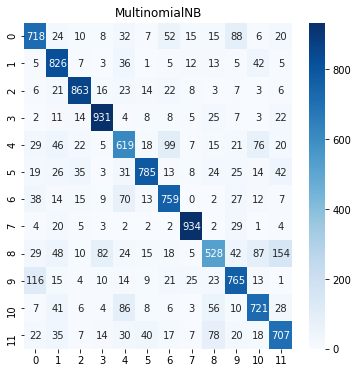

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       995
           1       0.73      0.86      0.79       960
           2       0.86      0.87      0.87       992
           3       0.86      0.90      0.88      1040
           4       0.64      0.63      0.64       977
           5       0.85      0.77      0.81      1025
           6       0.74      0.79      0.76       966
           7       0.91      0.93      0.92      1008
           8       0.67      0.51      0.58      1042
           9       0.73      0.75      0.74      1016
          10       0.72      0.74      0.73       976
          11       0.70      0.71      0.70       995

    accuracy                           0.76     11992
   macro avg       0.76      0.76      0.76     11992
weighted avg       0.76      0.76      0.76     11992



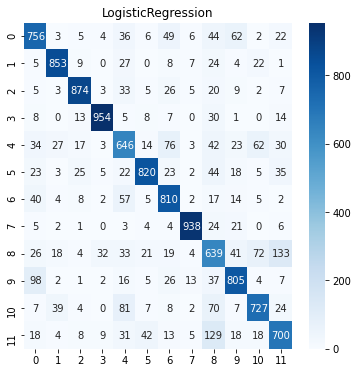

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       995
           1       0.89      0.89      0.89       960
           2       0.90      0.88      0.89       992
           3       0.94      0.92      0.93      1040
           4       0.65      0.66      0.66       977
           5       0.88      0.80      0.84      1025
           6       0.76      0.84      0.80       966
           7       0.95      0.93      0.94      1008
           8       0.57      0.61      0.59      1042
           9       0.79      0.79      0.79      1016
          10       0.79      0.74      0.77       976
          11       0.71      0.70      0.71       995

    accuracy                           0.79     11992
   macro avg       0.80      0.79      0.80     11992
weighted avg       0.80      0.79      0.80     11992



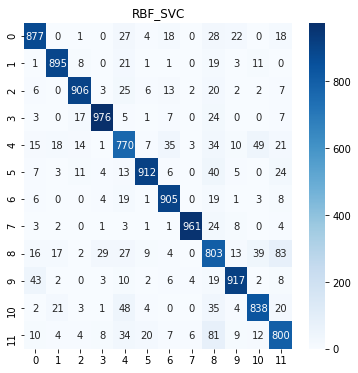

In [ ]:
accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    
    plt.figure(figsize=(6,6))
    plt.title(model_name)
    sns.heatmap(confusion_matrix(Y_test, model.predict(X_test)),annot=True,fmt='',cmap='Blues')
    plt.show()
    
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)
    print(classification_report(Y_test, model.predict(X_test)))

In [ ]:
accuracies

In [ ]:
# Performing 5-fold cross validation for better selection of the model best suited

pipelines = {}
for model_name in list(models.keys()):
    pipelines[model_name] = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in pipelines.items():
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model Name', 'fold_idx', 'Accuracy'])

plt.figure(figsize=(6,3))
sns.stripplot(x='Model Name', y='Accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
with open('RandomForest.pkl','rb') as file:
    model = pickle.load(file)

In [ ]:
text = ['garbage not cleared near PEC campus']
query = [" ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower() for x in text]

mapper[model.predict(query)[0]]